### In this notebook we read in data needed for MARBL and generate 1D input files. 
In MOM_input we need to specify the following initial condition files:

These files are currently read in from the direcotry "CESM_INPUTDIR", which defaults to "/glade/work/mlevy/cesm_inputdata". This is hardcoded in MOM6-examples/src/MOM6/src/tracer/MARBL_tracers.F90.


In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%cd /glade/work/mlevy/cesm_inputdata/
IC_FILE               =  xr.open_dataset('ecosys_jan_IC_omip_MOM_tx0.66v1_c211008.nc')
MARBL_FESEDFLUX_FILE  =  xr.open_dataset('fesedflux_total_reduce_oxic_tx0.66v1.c211020.nc')
MARBL_FEVENTFLUX_FILE =  xr.open_dataset('feventflux_5gmol_tx0.66v1.c211020.nc')


/glade/work/mlevy/cesm_inputdata


In [3]:
lat_array = IC_FILE['LAT']
lon_array = IC_FILE['LON']
#print(lat_array)

#We want to extract data at a certain lat/lon point. BATS location is 31.666667N, 64.166667W.
lat =  31.666667 
lon = -64.166667

# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(lat_array-lat)
abslon = np.abs(lon_array-lon)
c = np.maximum(abslat,abslon, )

([yloc],[xloc]) = np.where(c == np.min(c))

print(yloc,xloc)

313 334


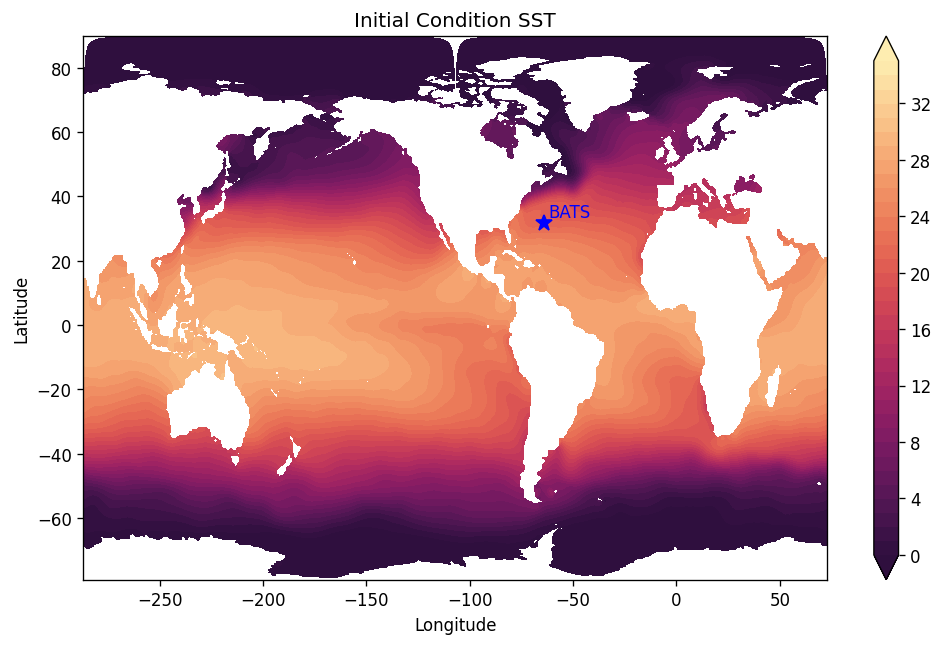

In [4]:
plt.figure(figsize=(10, 6),dpi=120)

plt.contourf(IC_FILE['LON'],IC_FILE['LAT'],IC_FILE['TEMP'][0,:],cmap=cmocean.cm.matter_r,vmin=0,vmax=35,levels=np.linspace(0,35,36),extend='both')
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Initial Condition SST')
plt.plot(lon_array[yloc,xloc],lat_array[yloc,xloc],'*b',markersize=10)

plt.text(lon_array[yloc,xloc]+2,lat_array[yloc,xloc]+2,'BATS',color='b')
plt.show()

In [6]:
IC_FILE_COLUMN               = IC_FILE.sel(NLAT=[yloc-1,yloc], NLON=[xloc-1,xloc]).rename_dims({'NLON':'lon','NLAT':'lat'})#.expand_dims(dim={'LAT':1,'LON':1},axis=[1,2])
MARBL_FESEDFLUX_FILE_COLUMN  = MARBL_FESEDFLUX_FILE.sel(NLAT=[yloc-1,yloc], NLON=[xloc-1,xloc]).rename_dims({'NLON':'lon','NLAT':'lat'})#.expand_dims(dim={'LAT':1,'LON':1},axis=[1,2])
MARBL_FEVENTFLUX_FILE_COLUMN = MARBL_FEVENTFLUX_FILE.sel(NLAT=[yloc-1,yloc], NLON=[xloc-1,xloc]).rename_dims({'NLON':'lon','NLAT':'lat'})#.expand_dims(dim={'LAT':1,'LON':1},axis=[1,2])  #leaving braces around [xloc] and [yloc] preserves that dimension



# print(IC_FILE_COLUMN)
# print( MARBL_FESEDFLUX_FILE_COLUMN)
# print(MARBL_FEVENTFLUX_FILE)


In [7]:
# for varname, da in IC_FILE_COLUMN.data_vars.items():
#     #print(da[:])
#     print(varname)
keys = list(IC_FILE_COLUMN.keys())
len(keys)

34

In [8]:
(IC_FILE_COLUMN)

<xarray.Dataset>
Dimensions:      (DEPTH: 102, lat: 2, lon: 2)
Coordinates:
  * DEPTH        (DEPTH) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
    LON          (lat, lon) float64 -64.68 -64.02 -64.69 -64.02
    LAT          (lat, lon) float64 31.1 31.1 31.66 31.66
Dimensions without coordinates: lat, lon
Data variables:
    TEMP         (DEPTH, lat, lon) float64 ...
    SALT         (DEPTH, lat, lon) float64 ...
    NO3          (DEPTH, lat, lon) float64 ...
    PO4          (DEPTH, lat, lon) float64 ...
    SiO3         (DEPTH, lat, lon) float64 ...
    O2           (DEPTH, lat, lon) float64 ...
    DIC          (DEPTH, lat, lon) float64 ...
    ALK          (DEPTH, lat, lon) float64 ...
    spC          (DEPTH, lat, lon) float64 ...
    spChl        (DEPTH, lat, lon) float64 ...
    spFe         (DEPTH, lat, lon) float64 ...
    spP          (DEPTH, lat, lon) float64 ...
    spCaCO3      (DEPTH, lat, lon) float64 ...
    diatC        (DEPTH, lat, lon) float64 ...
    diatChl      (DEPTH, lat, lon) float64 ...
    diatFe       (DEPTH, lat, lon) float64 ...
    diatP        (DEPTH, lat, lon) float64 ...
    diatSi       (DEPTH, lat, lon) float64 ...
    diazC        (DEPTH, lat, lon) float64 ...
    diazChl      (DEPTH, lat, lon) float64 ...
    diazFe       (DEPTH, lat, lon) float64 ...
    diazP        (DEPTH, lat, lon) float64 ...
    zooC         (DEPTH, lat, lon) float64 ...
    DOC          (DEPTH, lat, lon) float64 ...
    DOCr         (DEPTH, lat, lon) float64 ...
    DON          (DEPTH, lat, lon) float64 ...
    DONr         (DEPTH, lat, lon) float64 ...
    DOP          (DEPTH, lat, lon) float64 ...
    DOPr         (DEPTH, lat, lon) float64 ...
    NH4          (DEPTH, lat, lon) float64 ...
    Fe           (DEPTH, lat, lon) float64 ...
    Lig          (DEPTH, lat, lon) float64 ...
    DIC_ALT_CO2  (DEPTH, lat, lon) float64 ...
    ALK_ALT_CO2  (DEPTH, lat, lon) float64 ...
Attributes:
    date_created:     Thu Mar 14 14:15:56 MDT 2019
    Createdby:        ESMF_regridding.ncl
    Conventions:      SCRIP
    title:            tx0.66v1 Grid
    history:          created by github.com/marbl-ecosys/marbl-forcing/tree/e...
    input_file_list:  /glade/p/cesm/bgcwg/OMIPinit/woa13_temperature_OMIPinit...

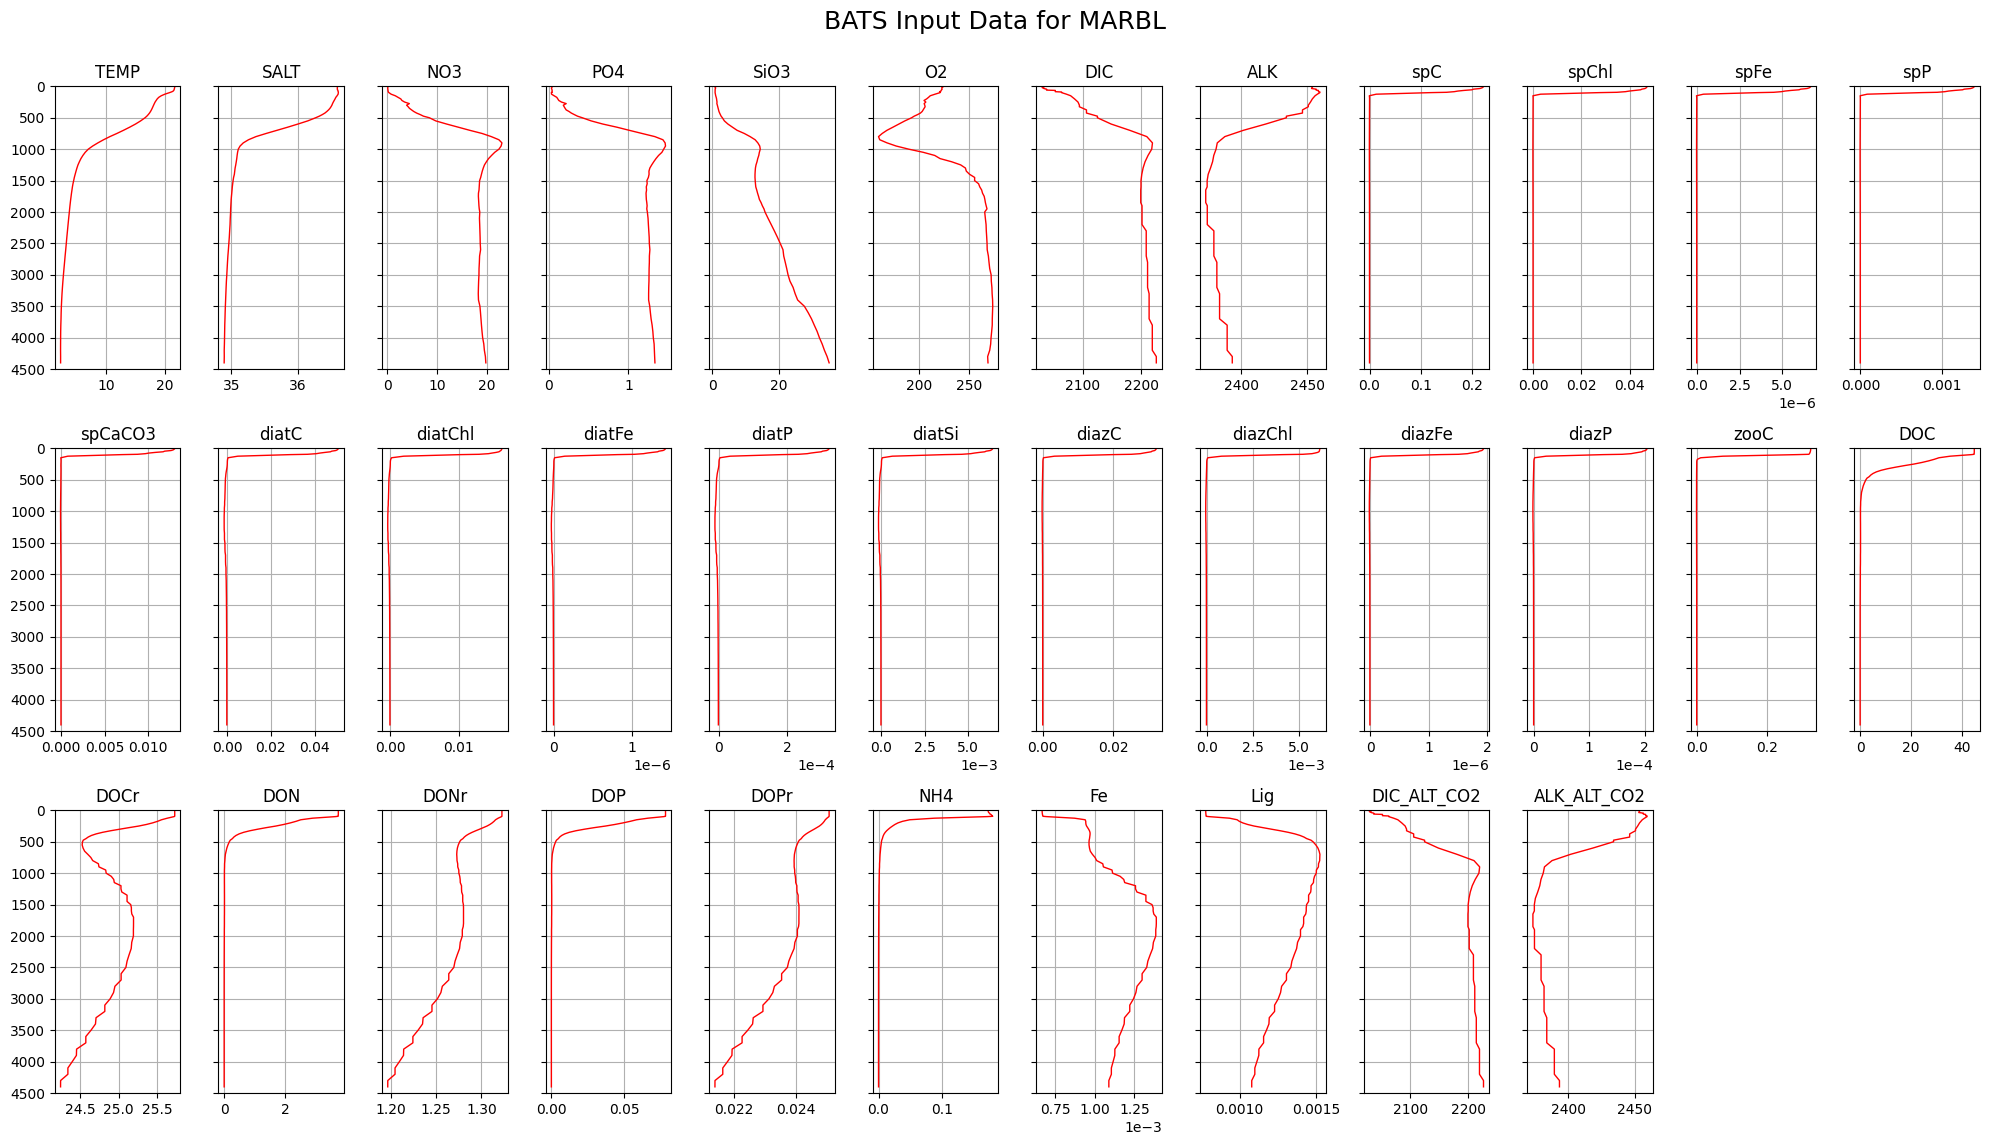

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=12, figsize=(20, 12), sharey = True, dpi=100)
fig.suptitle("BATS Input Data for MARBL", fontsize=18, y=0.95)

for key, ax in zip(keys, axs.ravel()):
    ax.plot(IC_FILE_COLUMN[key][:,0,0],IC_FILE_COLUMN.DEPTH,'r',linewidth=1)

    ax.set_ylim([4500, 0])
    ax.set_title(key)
    ax.grid()
    #ax.set_xlabel(IC_FILE_COLUMN[key].units)
    ax.ticklabel_format(style='plain', axis='x')
    if key in ['spFe','diatFe','diatSi','diazChl','diatP','diazFe','diazP','Fe']:
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

fig.delaxes(axs[-1][-1])
fig.delaxes(axs[-1][-2])
fig.tight_layout(rect=[0, 0, 1, 0.95])


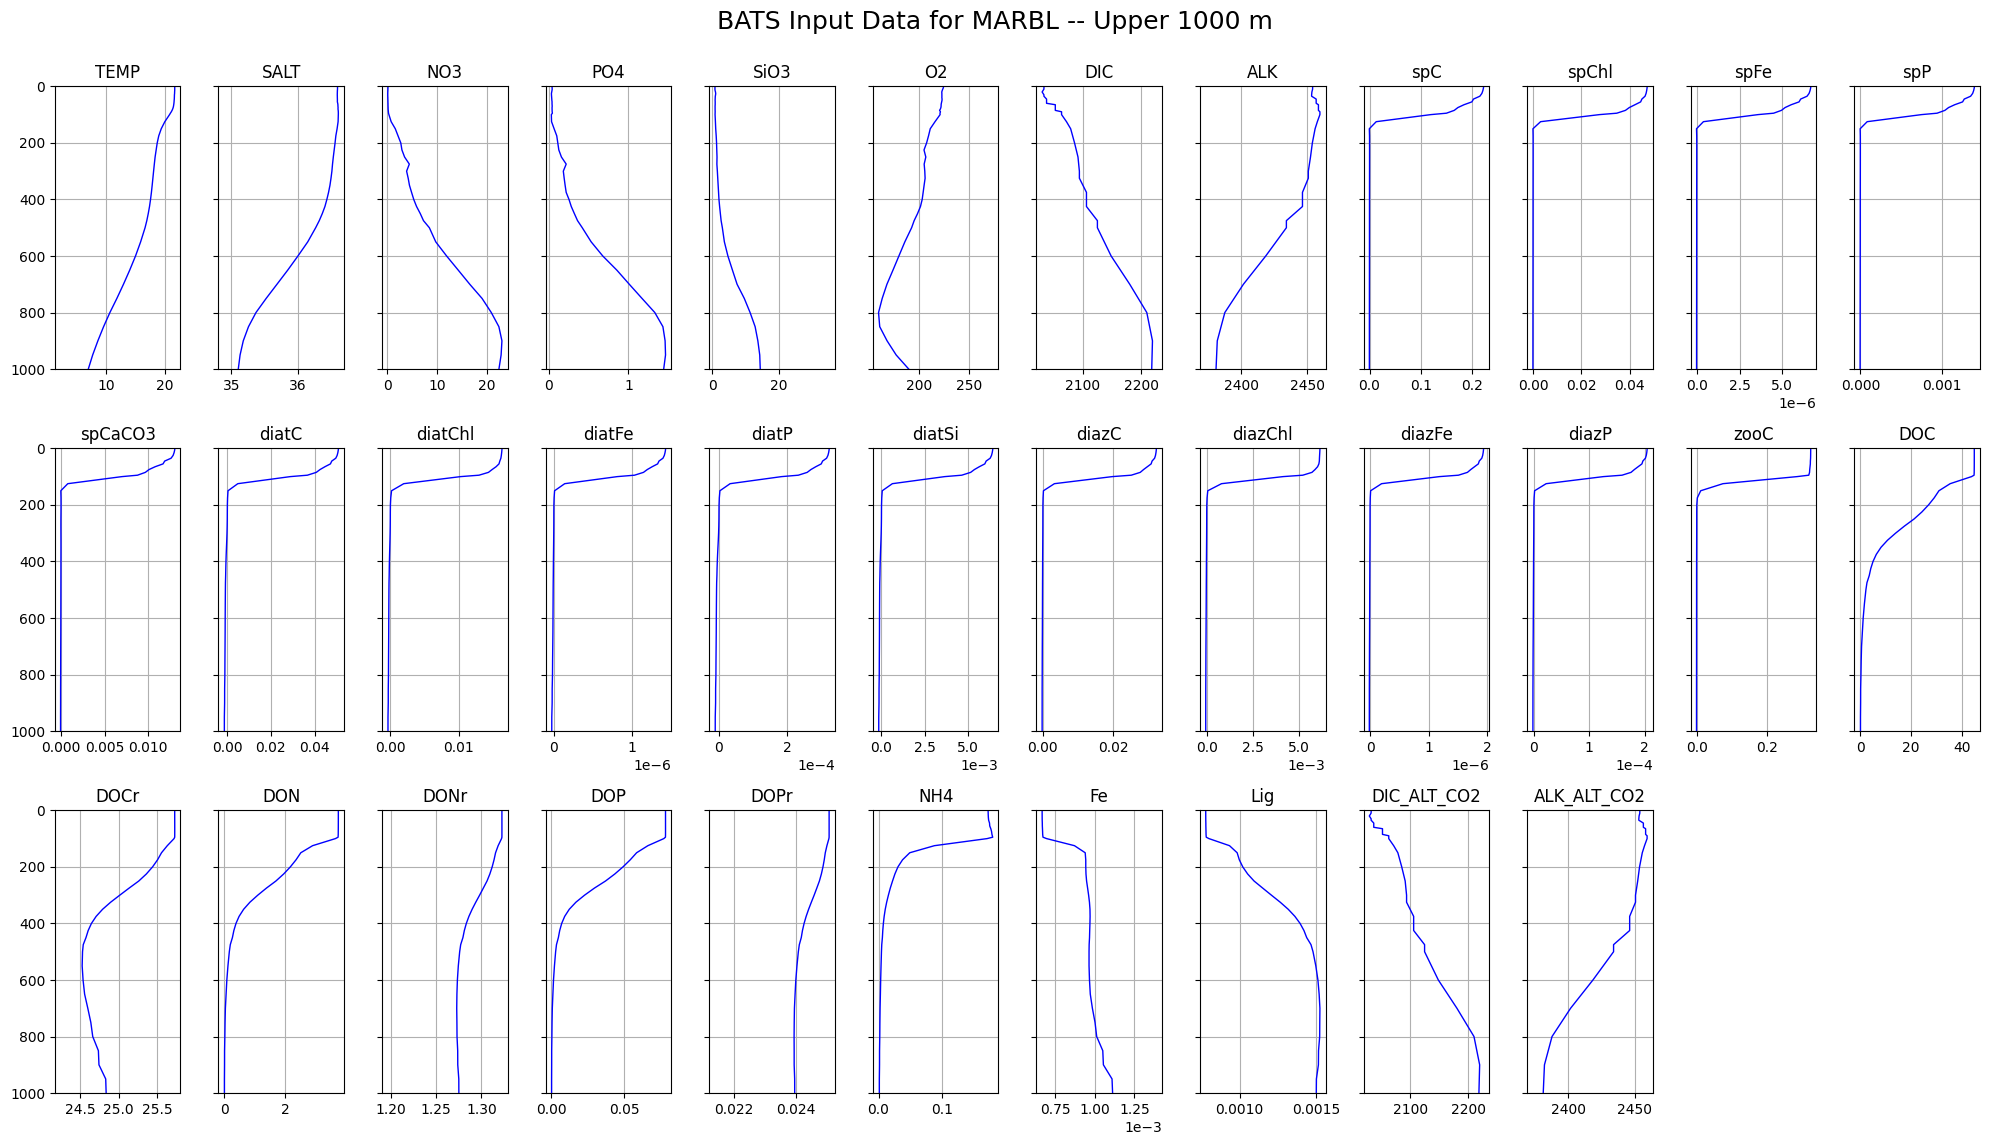

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=12, figsize=(20, 12), sharey = True, dpi=100)
fig.suptitle("BATS Input Data for MARBL -- Upper 1000 m", fontsize=18, y=0.95)

for key, ax in zip(keys, axs.ravel()):
    ax.plot(IC_FILE_COLUMN[key][:,0,0],IC_FILE_COLUMN.DEPTH,'b',linewidth=1)

    ax.set_ylim([1000, 0])
    ax.set_title(key)
    ax.grid()
    #ax.set_xlabel(IC_FILE_COLUMN[key].units)
    ax.ticklabel_format(style='plain', axis='x')
    if key in ['spFe','diatFe','diatSi','diazChl','diatP','diazFe','diazP','Fe']:
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

fig.delaxes(axs[-1][-1])
fig.delaxes(axs[-1][-2])
fig.tight_layout(rect=[0, 0, 1, 0.95])

## Finally save the MARBL column input files within the BATS input directory in my_single_column example directory

In [11]:

%cd /glade/u/home/eyankovsky/MOM6-examples/ocean_only/my_single_column/KPP/INPUT/BATS/
%rm IC_FILE_COLUMN.nc MARBL_FESEDFLUX_FILE_COLUMN.nc MARBL_FEVENTFLUX_FILE_COLUMN.nc
IC_FILE_COLUMN.to_netcdf('IC_FILE_COLUMN.nc', 'w')
MARBL_FESEDFLUX_FILE_COLUMN.to_netcdf('MARBL_FESEDFLUX_FILE_COLUMN.nc','w')
MARBL_FEVENTFLUX_FILE_COLUMN.to_netcdf('MARBL_FEVENTFLUX_FILE_COLUMN.nc','w')
%ls

testing_IC_FILE = xr.open_dataset('IC_FILE_COLUMN.nc')
testing_ICs = xr.open_dataset('ICs.nc')

/glade/u/home/eyankovsky/MOM6-examples/ocean_only/my_single_column/INPUT/BATS
forcing_monthly.nc  MARBL_FESEDFLUX_FILE_COLUMN.nc
forcing.nc          MARBL_FEVENTFLUX_FILE_COLUMN.nc
IC_FILE_COLUMN.nc   MOM_override
ICs.nc              WOA_column.nc
itides.nc
